# Study false detections around bright star masks
The radius of current HSC bright star masks, made by Andy Goulding, are selected by comparing the density of detections in increasingly large annuli around each bright stars with the average detection density. 

Still, false detections are present right outside the edge of masks for several objects. The aim of this notebook is to provide a plot of the number of detections as a function of increasing radius, around bright stars and beyond the edge of their mask, to visualize this problem.

## Options
You might want to change the two cells below.

The first one allows one to choose the path to the Butler repo we will read in, filter (note it only changes masks read in*, since we read detections from merged catalog), tracts, and binning options for the annuli.

The rerun in `/project/mschmitz/hscRerun/mynobg` is a subset of the 25 central patches in tract 9697, and had local background subtraction turned off.

Normally, we'd select bright objects to study from an outside catalog (Gaia). But for now, we are just reading in the actual mask region files, which means we have to jump through a few extra hoops.
If we want to look at whole tracts, we can just set `reselectBrightObjects` to `False`; if further selection of bright objects is needed, pass on a string.
The only one recognized at the moment is `boxAround`, where we pick a rectangular box around the furthest detections (because I only reran on the inner 25 patches of a tract for analysis sprint). This is admittedly hacky, but it's temporary, while we work with Andy's masks (and might prove useful anyway, eg to do this plot on the whole COSMOS field, that is circular).

\* not even that in the case of the Arcturus masks, that are all those from the I band despite the filenames containing a filter.

In [1]:
butlerPath = "/project/mschmitz/hscRerun/mynobg"

chosenFilter = "HSC-R" 
tractList = [9697] 
patchList = [["{},{}".format(i,j) for i in range(2,7) for j in range(2,7)]]

# Annuli parameters
annSize = 5 # radius of each consecutive annulus, in arcsec
nbAnnuli = 20 # number of annuli

# which detections to keep
reselectBrightObjects = "boxAround"#False

# print a few checkpoints, validation plots, etc
verbose = False

# which mask to load - if False, loads Arcturus masks
gouldingMask = True

Change this cell if you want to save the end plot:

In [2]:
# whether to save plots and what to call them
savePlots = True
plotStub = "beyondMask"
plotExt = ".png"

The rest of the notebook should not require any changes before being ran (though note the cell that actually computes the number counts can take up to a few minutes per tract, depending on annuli parameters).

## Set up
Usual imports:

In [3]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
from lsst import geom
import matplotlib.pyplot as plt
import os

And script with utility functions:

In [4]:
import helperFuncs

Token to avoid rereading the detections every time, eg if we want to play with annuli parameters

In [5]:
src_loaded = False 

Initialize Butler repo:

In [6]:
butler = Butler(butlerPath)

Path to masks. Note there's likely some that are repeated when using Arcturus near the edges of patches.

In [7]:
if gouldingMask:
    # filenames have lower case filter in them:
    if chosenFilter=='HSC-G':
        filter_lc = 'g'
    elif chosenFilter=='HSC-R':
        filter_lc = 'r'
    elif chosenFilter=='HSC-I':
        filter_lc = 'i'
    elif chosenFilter=='HSC-z':
        filter_lc = 'z'
    elif chosenFilter=='HSC-y':
        filter_lc = 'y'
    print(filter_lc)
    mask_path = "/datasets/hsc/BrightObjectMasks/GouldingMasksS18A/new_S18Amask_{}.reg".format(
                                            filter_lc)
else:
    mask_path = "/datasets/hsc/BrightObjectMasks/ArcturusMasks/" 

r


If plots are to be saved, make sure the folder exists:

In [8]:
if savePlots:
    if not os.path.isdir('plots/'):
        os.makedirs('plots/')

## Run
Warning: running cell below can take a while.

In [9]:
densities, brightMags, brightRads, brightCenters = [], [], [], []
for tract,patches in zip(tractList,patchList):
    # get sky map and WCS for this tract
    skymap = butler.get("deepCoadd_skyMap", tract=tract, filter=chosenFilter)
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    
    # convert annuli parameters to pixel
    pixScale = geom.radToArcsec(wcs.getPixelScale())
    annSizePix = annSize / pixScale
    
    # load detection catalog for each patch
    if verbose:
        print("Loading and appending all detections...")
    if not src_loaded:
        src = butler.get('deepCoadd_meas', tract=tract, patch=patches[0], 
                         filter=chosenFilter)
        src = src[src['detect_isPatchInner']]
        for patch in patches[1:]:
            patchSrc = butler.get('deepCoadd_meas', tract=tract, patch=patch, 
                                 filter=chosenFilter)
            patchSrc = patchSrc[patchSrc['detect_isPatchInner']]
            src.extend(patchSrc)
            src_loaded = True
    if verbose:
        print(" > Done.")
        
    # set up bright object selector if needed
    if reselectBrightObjects:
        if reselectBrightObjects == "boxAround":
            if verbose:
                print("Computing box boundaries...")
            # hacky box for a rectangular subset of patches within a tract:
            x0 = np.min(src["base_SdssCentroid_x"])
            xWidth = np.max(src["base_SdssCentroid_x"]) - x0 
            y0 = np.min(src["base_SdssCentroid_y"]) 
            yWidth = np.max(src["base_SdssCentroid_y"]) - x0 
            selector = lambda brightCenters, brightMags, brightRadii : helperFuncs.boxSelector(
                        brightCenters, brightRadii, x0, y0, xWidth, yWidth,
                        extraBuffer = annSizePix*nbAnnuli)
            if verbose:
                print(" > Done.")
        else:
            raiseValueError("reselectBrightObjects {} not implemented".format(
                            reselectBrightObjects))
    else:
        selector = None
        
    # load bright star masks
    if gouldingMask:
        # if we want to read from the files with all the masks;
        # mask_path should then be absolute path to there
        brightCenters, mags, rads = helperFuncs.extractBrightStarInfo( 
                                              tractInfo, mask_path, verbose=verbose)
    else:
        # if we are reading Arcturus, we need to concatenate them for
        # all patches of interest first
        for j,patch in enumerate(patches):
            thismask = mask_path + '{}/BrightObjectMask-{}-{}-{}.reg'.format(
                                        tract, tract, patch, chosenFilter)
            bc, bm, br = helperFuncs.extractBrightStarInfo(tractInfo,
                                           thismask, verbose=verbose)
            brightCenters += bc
            if j:
                mags = np.hstack((mags, bm))
                rads = np.hstack((rads, br))
            else:
                mags = bm
                rads = br
    # and further select among these if needed                                                   
    if selector is not None:
        brightIdx = selector(brightCenters, mags, rads)
        brightCenters = [brightCenters[j] for j in brightIdx]
        mags = mags[brightIdx]
        rads = rads[brightIdx]

    # compute counts in annulii
    if verbose:
        print("Computing number counts around bright objects...")
    counts, areas = helperFuncs.countsBeyondMask(src, nbAnnuli, annSizePix, brightCenters,
                                           rads, verbose=verbose)
    if verbose:
        print(" > Done.")
    # normalize by annulus area
    dens = counts / areas
    densities += [dens]
    brightMags += [mags]
    brightRads += [rads]

## Plot!

Compute distance to edge of each inner radius:

In [10]:
distanceToEdge = np.arange(0, annSize*nbAnnuli, annSize)

Plot a few individual objects first just to check:

In [11]:
if verbose:
    for dens, mags, rads, in zip(densities, brightMags, brightRads):
        for starIdx in np.argsort(mags)[::199]:
            brst = dens[starIdx]
            plt.plot(distanceToEdge, brst)
            plt.xlabel('Distance to mask edge (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.title('mag:{}'.format(mags[starIdx]))
            plt.show()
            plt.close()

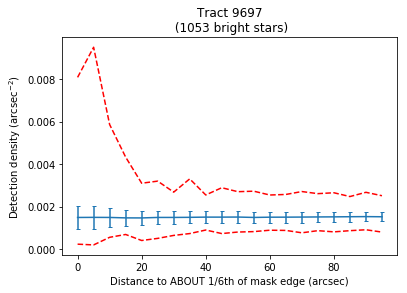

In [12]:
for tract, dens in zip(tractList, densities):
    # average detection densities around stars in this magnitude bin:
    magDen = np.mean(dens,axis=0)
    magDenStd = np.std(dens,axis=0)
    plt.errorbar(distanceToEdge, magDen, yerr=magDenStd, capsize=2)
    plt.plot(distanceToEdge, np.min(dens,axis=0), c='red', ls='--')
    plt.plot(distanceToEdge, np.max(dens,axis=0), c='red', ls='--')

    plt.title("Tract {}\n".format(tract)+" ({} bright stars)".format(len(dens)))
    plt.xlabel('Distance to ABOUT 1/6th of mask edge (arcsec)')
    plt.ylabel(r'Detection density (arcsec$^{-2}$)')
    
    if savePlots:
        plt.savefig("plots/" + plotStub + "tract{}".format(tract) + plotExt)
    plt.show()
    plt.close()